# Visualization, Recommendation, Prediction du film

In [ ]:
# le xgboot  c'est le successeur de gbbost. il est  tres moderne et on peut l'utiliser de resoudre des 
# problemes des classification et regression.
#il est populaire car , il est tres vite , nous donner beaucoup des hyperparametres avec laquelle on peut joue,
# il nous donne le meilleure accuracy par rapport a d'autres model comme svm,decision tree, naive bayes etc
#En bas de xgboost , c'est seulemen  l'algorithme  de decision tree.

#Notre projet consiste de trois phase
#1.La partie de visualisation utilisant pandas, seaborn
#partie de recommendation  utilisant le sckit learn qui contient (cosine fuction, Pearson ),On va utiliser 
# le 2 type de recommdation , content based et collaborative based(item-item)
# le troisieme partie sera la partie de prediction la ou on va utiliser le xgboot. il repond la question
#   'est-ce que  donner un film regarder par un utiliseur on peut predire un film similaire a lui a regarder'


# les dataset utlises sont movielens dataset(20M),imdb 5000  dataset,the movies dataset 

In [1]:
# importer les packages
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as sparse
import xgboost as xgb
import sklearn

from xgboost import XGBRegressor 
from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.model_selection import KFold,train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

#os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
saving=False

In [2]:
# overture des  dataframes

# 4803 films
tmdb_5000_movies=pd.read_csv("tmdb_5000_movies.csv",index_col="id")
tmdb_5000_credits=pd.read_csv("tmdb_5000_credits.csv",index_col="movie_id")
tmdb_5000=pd.merge(tmdb_5000_movies,tmdb_5000_credits,left_index=True,right_index=True)
tmdb_5000.dropna(subset=["release_date"],inplace=True)
tmdb_5000.replace(0,np.nan,inplace=True)

# 27278 films, 138493 utilisaters, 20000263 ratings
movielens_rating=pd.read_csv("rating.csv")
movielens_link=pd.read_csv("link.csv")
movielens_movie=pd.read_csv("movie.csv")
movielens_score=pd.read_csv("genome_scores.csv")
movielens_tag=pd.read_csv("genome_tags.csv")
movielens_dict={v:k for k,v in movielens_link.movieId.to_dict().items()}
movielens_rating.movieId=movielens_rating.movieId.apply(movielens_dict.get)
movielens_rating.userId-=1
movielens_score.movieId=movielens_score.movieId.apply(movielens_dict.get)
movielens_score.tagId-=1
movielens_tag.tagId-=1

## Visualization des dataframes (seulement pour visualisation)

In [3]:
# fonctions d'assistance(helper functions) pour gérer les fonctionnalités multi-hot
def group_indices(series,index="id"):
    d={}
    for i in range(series.size):
        l=eval(series.iloc[i])
        for x in l:
            d.setdefault(x[index],[])
            d[x[index]].append(i)
    return d

def get_groups(series,index="name"):
    s=set()
    for i in range(series.size):
        l=eval(series.iloc[i])
        for x in l:s.add(x[index])
    return list(s)

def multi_count(series,index="id"):
    return {k:len(v) for (k,v) in group_indices(series,index).items()}

def expand_multi_feature(df,column,index="id"):
    groups=group_indices(df[column],index=index)
    result=pd.DataFrame()
    for name,indices in groups.items():
        rows=df.iloc[indices].copy()
        rows[column]=name
        result=result.append(rows)
    return result

def multi_groupby(df,column,index="id"):
    return expand_multi_feature(df,column,index).groupby(column)

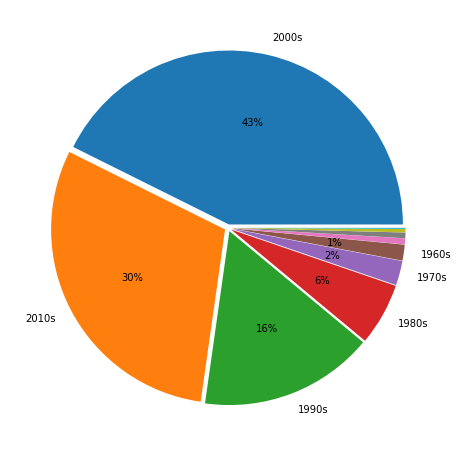

In [4]:
# nombre de films sortis au cours de chaque décennie
def count_pie(series,filename):
    counts=series.value_counts()
    counts=counts/counts.sum()
    labels=['' if num<0.01 else str(year) for (year,num) in counts.items()]
    f, ax = plt.subplots(figsize=(8, 8))
    explode = [0.02 if counts.iloc[i] < 100 else 0.001 for i in range(counts.size)]
    plt.pie(counts,labels=labels,autopct=lambda x:'{:1.0f}%'.format(x) if x > 1 else '',explode=explode)
    if saving:plt.savefig(filename,dpi=150)
    plt.show()

def count_decade_pie(df,filename):
    count_pie(df.release_date.dropna().apply(lambda x:str(int(x[:4])//10*10)+'s'),filename)
    
count_decade_pie(tmdb_5000,filename="pie_decade.png")

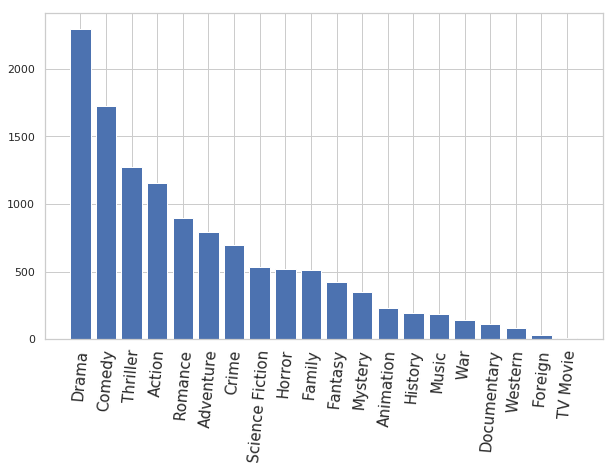

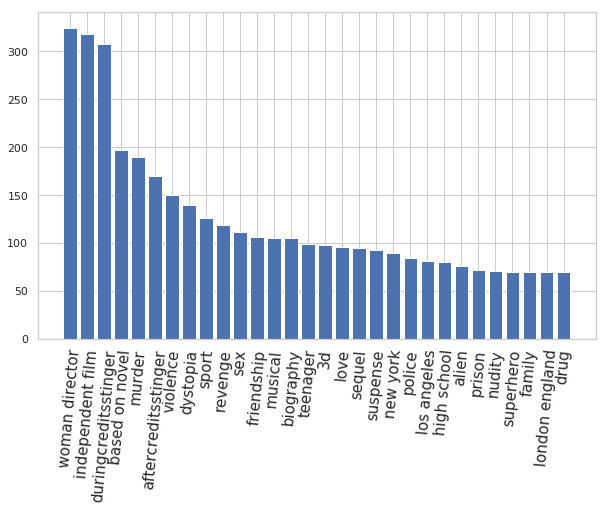

In [5]:
# nombre de films de différents genres et mots clés(keywords du film)
def multi_bar(series,filename):    
    sns.set(style="whitegrid")
    count=multi_count(series,"name")
    count=sorted(count.items(),key=lambda x:x[1],reverse=True)
    count=dict(count[:30])
    f, ax = plt.subplots(figsize=(10, 6))
    plt.xticks(rotation=85, fontsize=15)
    plt.bar(count.keys(),count.values(),align="center")
#     plt.pie(count.values(),labels=count.keys())
    if saving:plt.savefig(filename,bbox_inches="tight",dpi=100)
    plt.show()

multi_bar(tmdb_5000.genres,filename="bar_genres.png")
multi_bar(tmdb_5000.keywords,filename="bar_keywords.png")

## Recommendation du film(collaborative et content)

In [12]:
# definition des transformers
class SparseMatrixTransformer(BaseEstimator,TransformerMixin):
    def __init__(self,row=None,col=None,value=None,shape=None):
        self.row=row
        self.col=col
        self.value=value
        self.shape=shape
    
    def fit(self,X,y=None):
        self.shape=(X[self.row].max()+1,X[self.col].max()+1)
        return self
    
    def transform(self,X,y=None):
        if type(X) is pd.DataFrame:
            return sparse.csr_matrix(sparse.coo_matrix((X[self.value],(X[self.row],X[self.col])),self.shape))
        else:
            return sparse.csr_matrix(sparse.coo_matrix((X[:,2],(X[:,0],X[:,1])),self.shape))
    
user_movie_transformer=SparseMatrixTransformer(row="userId",col="movieId",value="rating").fit(movielens_rating)
movie_tag_transformer=SparseMatrixTransformer(row="movieId",col="tagId",value="relevance",shape=(user_movie_transformer.shape[1],movielens_tag.tagId.max()+1))

In [13]:
# creation d'une classe qui sera la base de notre recommendation
class RecommenderMixin(BaseEstimator,TransformerMixin):
    def __init__(self,n_rec=10):
        self.n_rec=n_rec
    
    def evaluate(self,X_train,X_valid,silent=False):
        n_users,n_items=X_train.shape
        X=(X_train+X_valid).T
        item_rating=np.array([row.data.mean() if row.nnz else 0 for row in X])
        item_rating[np.isnan(item_rating)]
        mean_rating=X.data.mean()
        if not silent:print("predicting...")
        recommend=self.predict(X_train)
        if not silent:print("evaluating...")
        intersect=np.asarray(X_valid[np.arange(n_users).repeat(self.n_rec),recommend.flatten()].reshape(n_users,-1))
        hit=(intersect!=0).sum()
        precision=hit/recommend.size
        recall=hit/X_valid.nnz
        coverage=np.unique(recommend).size/n_items
        hit_rating=(intersect[intersect!=0]).mean()
        indices=recommend[(intersect!=0)]
        recom_rating=np.average(item_rating[indices])
        print("accuracy=%.4f"%precision)
        print("recall=%.4f"%recall)
        print("cover=%.4f"%coverage)
        print("user's vote to the hit movies=%.4f"%(hit_rating))
        print("average vote to the hit movies=%.4f"%(recom_rating))
        print("average vote to all movies=%.4f"%(mean_rating))
        
    def fit_predict(self,X,y=None):
        return self.fit(X,y).predict(X)

In [14]:
# item based colaborative filtering(item to item )#on peut aussi utiliser user-user mais il n'est pas pratique
#puisque le desir de utilisateur peut changer , mais celui de item(film) sera constant 
# calculer la similitude entre les films en fonction du vote des utilisateurs sur les films
class ItemBasedCF(RecommenderMixin):
    def __init__(self,n_rec=10,n_sim=20,file_name=None,baseline=3.0):
        super().__init__(n_rec=n_rec)
        self.baseline=baseline
        if file_name:
            self.similar_matrix=sparse.load_npz(file_name)
            self.n_sim=self.similar_matrix.shape[1]
        else:
            self.n_sim=n_sim
            self.similar_matrix=None
        
    def save(self,file_name):
        sparse.save_npz(file_name,self.similar_matrix)

    def fit(self,X,y=None,silent=False):
        if not silent:print("calculating the similar matrix...")
        n_users,n_items=X.shape
        user_movie=X.copy()
        user_movie.data-=self.baseline
        norms=sparse.linalg.norm(user_movie,axis=0)
        norms[norms==0]=1
        user_movie*=sparse.diags(1/norms)
        movie_sim_matrix=user_movie.T*user_movie
        if not silent:print("sparsifying similar matrix...")
        row=np.arange(n_items).repeat(self.n_sim)
        col=np.array([np.argpartition(row.toarray().flatten(),-self.n_sim)[-self.n_sim:].copy() for row in movie_sim_matrix]).flatten()
        self.similar_matrix=sparse.csr_matrix(sparse.coo_matrix((np.asarray(movie_sim_matrix[row,col]).flatten(),(row,col)),(n_items,n_items)))
        if not silent:print("fitting done.")
        return self
    
    def transform(self,X,y=None):
        user_movie=X.copy()
        user_movie.data-=self.baseline
        return user_movie*self.similar_matrix
    
    def predict(self,X):
        watched_movies=X.copy()
        watched_movies.data.fill(np.inf)
        movie_favor=self.transform(X)-watched_movies
        return np.array([np.argpartition(row.toarray().flatten(),-self.n_rec)[-self.n_rec:].copy() for row in movie_favor])
    
# itemCF=ItemBasedCF(file_name="ItemBasedCF.npz")

In [15]:
# content based recommendation system
# calculer la similitude entre les films en fonction de leur pertinence pour chaque balise
class ContentBasedRS(RecommenderMixin):
    def __init__(self,n_rec=10,n_sim=100,file_name=None,baseline=3.0):
        super().__init__(n_rec=n_rec)
        self.baseline=baseline
        if file_name:
            self.similar_matrix=sparse.load_npz(file_name)
            self.n_sim=self.similar_matrix.shape[1]
        else:
            self.n_sim=n_sim
            self.similar_matrix=None
        
    def save(self,file_name):
        sparse.save_npz(file_name,self.similar_matrix)

    def fit(self,X,y=None,silent=False):
        n_items,n_features=X.shape
        if not silent:print("sparsifying relevance matrix...")
        row=np.arange(n_items).repeat(self.n_sim)
        col=np.array([np.argpartition(row.toarray().flatten(),-self.n_sim)[-self.n_sim:].copy() for row in X]).flatten()
        relevance_matrix=sparse.csr_matrix(sparse.coo_matrix((np.asarray(X[row,col]).flatten(),(row,col)),(n_items,n_features)))
        if not silent:print("calculating the similar matrix...")
        movie_sim_matrix=relevance_matrix*relevance_matrix.T
        if not silent:print("sparsifying similar matrix...")
        row=np.arange(n_items).repeat(self.n_sim)
        col=np.array([np.argpartition(row.toarray().flatten(),-self.n_sim)[-self.n_sim:].copy() for row in movie_sim_matrix]).flatten()
        self.similar_matrix=sparse.csr_matrix(sparse.coo_matrix((np.asarray(movie_sim_matrix[row,col]).flatten(),(row,col)),(n_items,n_items)))
        if not silent:print("fitting done.")
        return self
    
    def transform(self,X,y=None):
        user_movie=X.copy()
        user_movie.data-=self.baseline
        return user_movie*self.similar_matrix
    
    def predict(self,X):
        watched_movies=X.copy()
        watched_movies.data.fill(np.inf)
        movie_favor=self.transform(X)-watched_movies
        return np.array([np.argpartition(row.toarray().flatten(),-self.n_rec)[-self.n_rec:].copy() for row in movie_favor])
    
# contentRS=ContentBasedCF(file_name="ContentBasedRS.npz")

In [16]:
# on entraine notre modele content based
contentRS=ContentBasedRS()
%time contentRS.fit(movie_tag_transformer.transform(movielens_score))
if saving:contentRS.save("ContentBasedRS.npz")

sparsifying relevance matrix...
calculating the similar matrix...
sparsifying similar matrix...
fitting done.
CPU times: user 3min 1s, sys: 4.46 s, total: 3min 6s
Wall time: 3min 6s


In [17]:
# on entraine notre modele collaborative 
itemCF=ItemBasedCF()
%time itemCF.fit(user_movie_transformer.transform(movielens_rating))
if saving:itemCF.save("ItemBasedCF.npz")

calculating the similar matrix...
sparsifying similar matrix...
fitting done.
CPU times: user 1min 25s, sys: 14.6 s, total: 1min 40s
Wall time: 1min 40s


In [18]:
# exemple des films les plus similaires à un film spécifié(content based)
def movie_similar(rs,movie):
    index=rs.similar_matrix[movie].indices
    return pd.merge(movielens_movie.iloc[index].reset_index(drop=True),pd.DataFrame({"similar":rs.similar_matrix[movie,index].toarray().flatten()}),left_index=True,right_index=True).sort_values("similar",ascending=False).reset_index(drop=True)
    
movie_similar(itemCF,17506)

,movieId,title,genres,similar
0,88140,Captain America: The First Avenger (2011),Action|Adventure|Sci-Fi|Thriller|War,1.000000
1,86332,Thor (2011),Action|Adventure|Drama|Fantasy|IMAX,0.482128
2,89745,"Avengers, The (2012)",Action|Adventure|Sci-Fi|IMAX,0.413647
3,77561,Iron Man 2 (2010),Action|Adventure|Sci-Fi|Thriller|IMAX,0.401208
4,87232,X-Men: First Class (2011),Action|Adventure|Sci-Fi|Thriller|War,0.390539
5,102125,Iron Man 3 (2013),Action|Sci-Fi|Thriller|IMAX,0.354732
6,95510,"Amazing Spider-Man, The (2012)",Action|Adventure|Sci-Fi|IMAX,0.331462
7,91542,Sherlock Holmes: A Game of Shadows (2011),Action|Adventure|Comedy|Crime|Mystery|Thriller,0.323050
8,110102,Captain America: The Winter Soldier (2014),Action|Adventure|Sci-Fi|IMAX,0.321387
9,106072,Thor: The Dark World (2013),Action|Adventure|Fantasy|IMAX,0.298413


In [19]:
# exemple de films recommandés pour un film spécifié (collaborative based )
def user_recommend(rs,user):
    return movielens_movie.iloc[rs.predict(user_movie_transformer.transform(movielens_rating)[[user]]).flatten()].reset_index(drop=True)
    
user_recommend(itemCF,5)

,movieId,title,genres
0,318,"Shawshank Redemption, The (1994)",Crime|Drama
1,440,Dave (1993),Comedy|Romance
2,1210,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Sci-Fi
3,539,Sleepless in Seattle (1993),Comedy|Drama|Romance
4,805,"Time to Kill, A (1996)",Drama|Thriller
5,150,Apollo 13 (1995),Adventure|Drama|IMAX
6,356,Forrest Gump (1994),Comedy|Drama|Romance|War
7,36,Dead Man Walking (1995),Crime|Drama
8,457,"Fugitive, The (1993)",Thriller
9,11,"American President, The (1995)",Comedy|Drama|Romance


In [20]:
# voir les films déjà regardés d'un film spécifié
def user_watched(user):
    watched_movies=movielens_rating[movielens_rating.userId==user]
    return pd.DataFrame({"title":movielens_movie.title.iloc[watched_movies.movieId],"genres":movielens_movie.genres.iloc[watched_movies.movieId],"rating":watched_movies.rating.values})

user_watched(5)

,title,genres,rating
0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5.0
2,Grumpier Old Men (1995),Comedy|Romance,3.0
6,Sabrina (1995),Comedy|Romance,5.0
16,Sense and Sensibility (1995),Drama|Romance,5.0
51,Mighty Aphrodite (1995),Comedy|Drama|Romance,5.0
61,Mr. Holland's Opus (1995),Drama,5.0
133,Down Periscope (1996),Comedy,3.0
138,Up Close and Personal (1996),Drama|Romance,4.0
139,"Birdcage, The (1996)",Comedy,5.0
257,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi,4.0


In [21]:
# évaluer et comparer le système de recommandation
rating_train,rating_valid=train_test_split(movielens_rating[["userId","movieId","rating"]])
rating_train=user_movie_transformer.transform(rating_train)
rating_valid=user_movie_transformer.transform(rating_valid)
%time ItemBasedCF().fit(rating_train).evaluate(rating_train,rating_valid)
%time ContentBasedRS().fit(movie_tag_transformer.transform(movielens_score)).evaluate(rating_train,rating_valid)

calculating the similar matrix...
sparsifying similar matrix...
fitting done.
predicting...
evaluating...
accuracy=0.2706
recall=0.0749
cover=0.1889
user's vote to the hit movies=4.2957
average vote to the hit movies=4.0459
average vote to all movies=3.5255
CPU times: user 1min 35s, sys: 6.56 s, total: 1min 42s
Wall time: 1min 42s
sparsifying relevance matrix...
calculating the similar matrix...
sparsifying similar matrix...
fitting done.
predicting...
evaluating...
accuracy=0.1242
recall=0.0344
cover=0.1465
user's vote to the hit movies=4.3634
average vote to the hit movies=4.0527
average vote to all movies=3.5255
CPU times: user 4min 1s, sys: 8.22 s, total: 4min 9s
Wall time: 4min 9s


## Prediction

Prédisons le vote moyen des films.

In [22]:
data=tmdb_5000.dropna(subset=["vote_count"]).copy()
data["release_year"]=data.release_date.apply(lambda x:int(x[:4]))
data=data[data.vote_count>=100].copy()

In [23]:
# on convertir les strings(lettre) des variable independant en nombres(one-hot encodings)
# parceque xgboost marche seulement avec les nombres
pd.DataFrame({
    "cast":pd.Series(multi_count(tmdb_5000.cast)).describe(),
    "crew":pd.Series(multi_count(tmdb_5000.crew)).describe(),
    "companies":pd.Series(multi_count(tmdb_5000.production_companies)).describe(),
    "countries":pd.Series(multi_count(tmdb_5000.production_countries,index="iso_3166_1")).describe(),
    "languages":pd.Series(multi_count(tmdb_5000.spoken_languages,index="iso_639_1")).describe(),
    "keywords":pd.Series(multi_count(tmdb_5000.keywords)).describe(),
    "genres":pd.Series(multi_count(tmdb_5000.genres)).describe(),
}).round(2).astype(object)

,cast,crew,companies,countries,languages,keywords,genres
count,54588,52885,5047,88,87,9813,20
mean,1.95,2.45,2.71,73.14,79.74,3.69,608
std,2.83,3.49,10.61,427.41,483.02,9.67,606.93
min,1,1,1,1,1,1,8
25%,1,1,1,1,1,1,174.75
50%,1,1,1,3,4,1,468.5
75%,2,2,2,18.25,17.5,3,816
max,67,104,319,3956,4485,324,2297


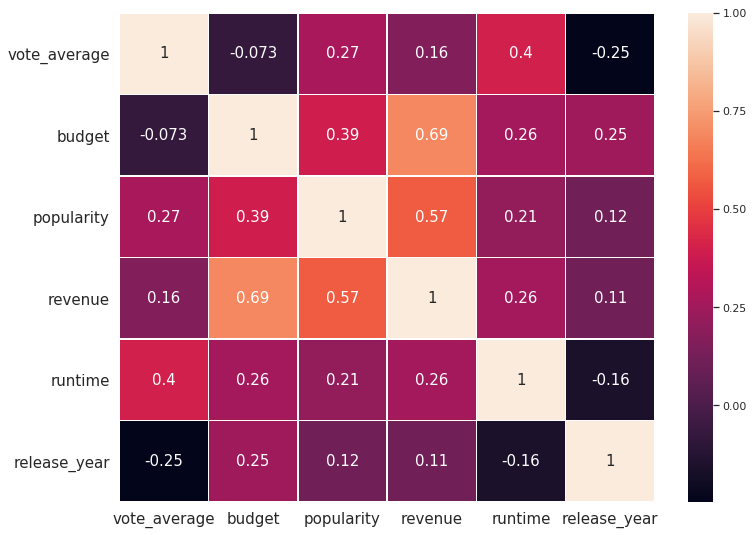

In [24]:
# corrélation entre les caractéristiques numériques
def plot_corr(df,filename):
    plt.subplots(figsize=(12, 9))
    sns.heatmap(df.corr(),annot=True,linewidths=.5,annot_kws={"fontsize":15})
    plt.yticks(rotation=0,fontsize=15)
    plt.xticks(rotation=0,fontsize=15)
    if saving:plt.savefig(filename,dpi=150)
    plt.show()

plot_corr(data[["vote_average","budget","popularity","revenue","runtime","release_year"]],filename="corr.png")

In [26]:
# selection des certains  caractéristiques independants
label_name="vote_average"
numeric_features=["budget","runtime","popularity","revenue","release_year"]
multi_hot_features=["genres"]

In [27]:
# definition des  transformers
class MultiHotEncoder(BaseEstimator,TransformerMixin):
    def __init__(self):
        self.categories=[]
    
    def fit(self,X,y=None):
        self.categories=[]
        for name,series in X.iteritems():
            df=to_split(series).str.get_dummies()
            df.columns=name+"_"+df.columns
            self.categories+=list(df.columns)
        return self
    
    def transform(self,X,y=None):
        result=pd.DataFrame(index=X.index)
        for name,series in X.iteritems():
            df=to_split(series).str.get_dummies()
            df.columns=name+"_"+df.columns
            result=result.join(df)
        for i,cate in enumerate(self.categories):
            if result.columns[i]!=cate:
                result.insert(i,cate,0)
        return result.reset_index(drop=True)

    
def to_split(series,sep="|",index="name",threshold=0):
    count=multi_count(series,index)
    result=pd.Series(index=series.index)
    for i in range(series.size):
        l=eval(series.iloc[i])
        result.iloc[i]=""
        for x in l:
            if count[x[index]]>=threshold:
                result.iloc[i]+=x[index]+sep
    return result

class DataFrameTransformer(BaseEstimator,TransformerMixin):
    def __init__(self,transformers):
        self.transformers=transformers
        
    def fit(self,X,y=None):
        for i in self.transformers:
            if i[1]!="passthrough" and i[1]!="drop":i[1].fit(X[i[2]])
        return self
    
    def transform(self,X,y=None):
        result=pd.DataFrame(index=range(X.shape[0]))
        for i in self.transformers:
            if i[1]=="passthrough":x=X[i[2]].reset_index(drop=True)
            elif i[1]=="drop":continue
            else:x=i[1].transform(X[i[2]])
            if type(x) is not pd.DataFrame:x=pd.DataFrame(x,columns=i[2])
            result=result.join(x)
        return result

In [28]:
preprocessor=DataFrameTransformer([
    ("numeric","passthrough",numeric_features),
])
xgb_params={"silent":True,"eta":0.01,'subsample': 0.8,'colsample_bytree': 0.8,"max_depth":5}
dmat=xgb.DMatrix(preprocessor.fit_transform(data),data[label_name])#pour ameliorer l'accuracy et vitesse de notre modele
xgb.cv(xgb_params,dmat,num_boost_round=20000,early_stopping_rounds=500,nfold=4,seed=42,feval=lambda preds,dmat:("R2score",sklearn.metrics.r2_score(dmat.get_label(),preds))).iloc[[-1]]
#cv(cross validation un technique pour prevenir underfitting et diminuer notre fonction loss)

/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/conda/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


,train-R2score-mean,train-R2score-std,train-rmse-mean,train-rmse-std,test-R2score-mean,test-R2score-std,test-rmse-mean,test-rmse-std
752,0.686275,0.009423,0.467343,0.005496,0.466709,0.033595,0.608674,0.012726


In [29]:
preprocessor=DataFrameTransformer([
    ("numeric","passthrough",numeric_features),
    ("multihot",MultiHotEncoder(),multi_hot_features),
])

In [30]:
xgb_params={"silent":True,"eta":0.01,'subsample': 0.8,'colsample_bytree': 0.7,"max_depth":7}# definition de quelque parametre pour booster notre modele
# en fait c'est question de 'try and error'.on joue avec notre hyperparametres jusqu'a on augmente notre accuracy
dmat=xgb.DMatrix(preprocessor.fit_transform(data),data[label_name])
result=xgb.cv(xgb_params,dmat,num_boost_round=20000,early_stopping_rounds=500,nfold=4,seed=42,feval=lambda preds,dmat:("R2score",sklearn.metrics.r2_score(dmat.get_label(),preds)))
result.iloc[[-1]]

/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/conda/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


,train-R2score-mean,train-R2score-std,train-rmse-mean,train-rmse-std,test-R2score-mean,test-R2score-std,test-rmse-mean,test-rmse-std
815,0.880091,0.002856,0.288941,0.002273,0.579301,0.020804,0.540731,0.006675


In [31]:
X=preprocessor.fit_transform(data)
y=data[label_name]
train_X,valid_X,train_y,valid_y=train_test_split(X,y)
train_mat=xgb.DMatrix(train_X,train_y)
valid_mat=xgb.DMatrix(valid_X,valid_y)
model=xgb.train(xgb_params,train_mat,num_boost_round=result.shape[0])

/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


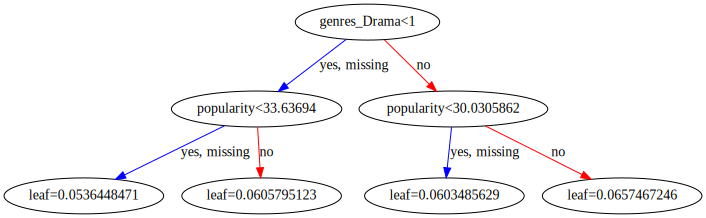

In [32]:
xgb.to_graphviz(model)

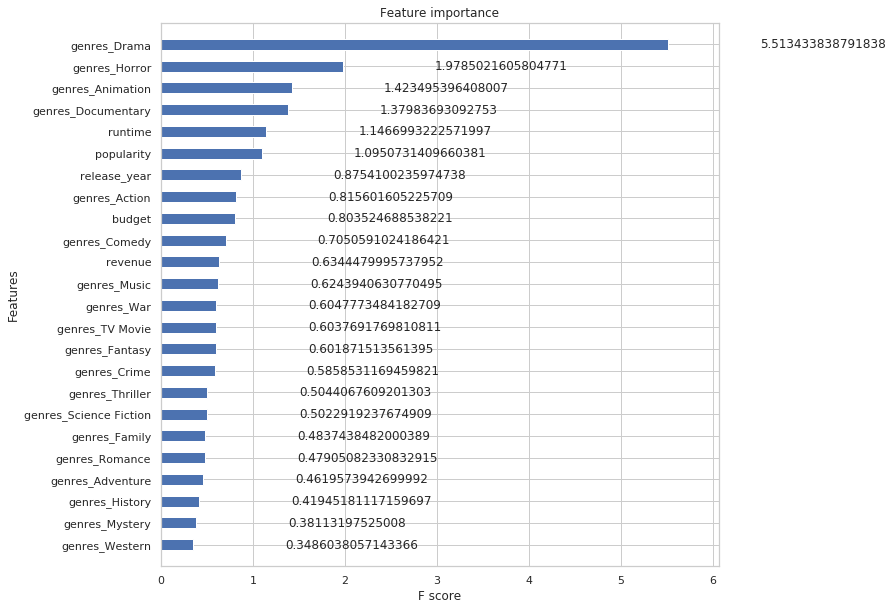

In [33]:
def plot_importance(model,filename,importance_type="weight"):
    f,ax=plt.subplots(figsize=(10,10))
    xgb.plot_importance(model,height=0.5,ax=ax,importance_type=importance_type)
    if saving:plt.savefig(filename,dpi=150,bbox_inches="tight")
    plt.show()
    
plot_importance(model,importance_type="gain",filename="boost_tree_importance.png")